In [23]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from scipy.stats import ttest_ind
from nzmeltwater.util import cleanocn
from xesmf import Regridder

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 12

### Load sea surface height for control and meltwater experiments

In [24]:
croot = Path("../data/processed/HadGEM3-GC31-LL")

expts = ["historical", "ssp585"]

In [1]:
ctrldata = {}

for exp in expts:
    print(exp)

    if exp == "historical":
        histdir = croot.joinpath("historical", "Omon", "zos")
        sspdir = croot.joinpath("ssp245", "Omon", "zos")

        tspan = slice("2015-01", "2020-12")

        histfiles = sorted(list(histdir.glob("zos*historical_r*.nc")))
        sspfiles = sorted(list(sspdir.glob("zos*5_r*201501-*.nc")))
        
        ensmem = [f.name.split("_")[4] for f in histfiles]

        dshist = xr.open_mfdataset(
            histfiles, combine="nested", concat_dim="ensmem", parallel=True
        )

        dshist = dshist.assign_coords({"ensmem": ("ensmem", ensmem)})

        dahist = dshist["zos"].sel(time=slice("1992-01", "2014-12"))
    else:
        sspdir = croot.joinpath("ssp585", "Omon", "zos")
        tspan = slice("2015-01", "2100-12")
        
        sspfiles = sorted(list(sspdir.glob("zos*5_r*210012.nc")))

    
    ensmem = [f.name.split("_")[4] for f in sspfiles]

    dsssp = xr.open_mfdataset(
        sspfiles, combine="nested", concat_dim="ensmem", parallel=True
    )

    dsssp = dsssp.assign_coords({"ensmem": ("ensmem", ensmem)})

    dassp = dsssp["zos"].sel(time=tspan)

    if exp == "historical":
        dac = xr.concat((dahist, dassp), dim="time")
    else:
        dac = dassp

    ctrldata[exp] = dac.rename({"latitude": "lat", "longitude": "lon"})

In [41]:
sofdata = {}
for exp in expts:
    print(exp)

    if exp == "historical":
        sofdir = croot.joinpath("hist-antwater-92-11", "Omon", "zos")
        soffiles = sorted(list(sofdir.glob("*92-11_r*.nc")))
    else:
        sofdir = croot.joinpath("ssp585-ismip6-water", "Omon", "zos")
        soffiles = sorted(list(sofdir.glob("*water_r*.nc")))    

    ensmem = [f.name.split("_")[4] for f in soffiles]

    dssof = cleanocn(
        xr.open_mfdataset(
            soffiles, combine="nested", concat_dim="ensmem", parallel=True
        )
    )

    dssof = dssof.assign_coords({"ensmem": ("ensmem", ensmem)})

    dasof = dssof["zos"].isel(i=slice(1, -1), j=slice(1, -1))

    sofdata[exp] = dasof

historical
ssp585


In [42]:
def stattest2d(ctrl, expt):
    tstat, pval = ttest_ind(ctrl, expt)

    xpval = xr.DataArray(
        pval,
        coords={
            "lat": (("j", "i"), ctrl.lat.data),
            "lon": (("j", "i"), ctrl.lon.data),
        },
        dims=["j", "i"],
    )

    tanom = (expt - ctrl).mean("year")

    return xpval, tanom


def rectilinear_regrid(da):
    # Regrid p values to rectilinear grid so that contourf works
    rlat = np.arange(-90, 91)
    rlon = np.arange(-180, 181)

    dsout = xr.DataArray(
        np.zeros((rlat.size, rlon.size)),
        dims=["j", "i"],
        coords={"lat": ("j", rlat), "lon": ("i", rlon)},
    )

    regridder = Regridder(da, dsout, method="bilinear")
    da_r = regridder(da)

    return da_r

### Compute seasonal anomalies and p-values

In [43]:
def seas_subset(data):
    data_seas = data.resample(time="QE-FEB").mean("time").compute()
    data_seas = data_seas.isel(time=slice(1, -1))
    mam = data_seas.isel(time=slice(0, None, 4)).groupby("time.year").mean("time")
    jja = data_seas.isel(time=slice(1, None, 4)).groupby("time.year").mean("time")
    son = data_seas.isel(time=slice(2, None, 4)).groupby("time.year").mean("time")
    djf = data_seas.isel(time=slice(3, None, 4)).groupby("time.year").mean("time")

    out = xr.concat([djf, mam, jja, son], dim="season")
    out = out.assign_coords({"season": ("season", ["DJF", "MAM", "JJA", "SON"])})

    return out

In [44]:
def stattestseas(ctrl, expt):
    tstat, pval = ttest_ind(ctrl, expt, axis=0)

    if ctrl.lat.ndim == 2:
        coords = {
            "lat": (ctrl.lat.dims, ctrl.lat.data),
            "lon": (ctrl.lon.dims, ctrl.lon.data),
        }
    else:
        coords = {
            "lat": ("j", ctrl.lat.data),
            "lon": ("i", ctrl.lon.data),
        }

    xpval = xr.DataArray(pval, dims=("j", "i"), coords=coords)

    tanom = (expt - ctrl).mean("year")

    return xpval, tanom

In [45]:
anomdictseas = {}
pvaldictseas = {}

for exp in expts:
    print(exp)
    if exp == "historical":
        tspan = slice("2011-01", "2020-12")
    else:
        tspan = slice("2071-01", "2100-12")

    ctrl = seas_subset(
        ctrldata[exp].sel(ensmem=sofdata[exp].ensmem, time=tspan).mean("ensmem")
    )
    expt = seas_subset(sofdata[exp].sel(time=tspan).mean("ensmem"))

    rlat = np.arange(-90, 91)
    rlon = np.arange(-180, 181)

    dsout = xr.DataArray(
        np.zeros((4, rlat.size, rlon.size)),
        dims=["season", "j", "i"],
        coords={"season": ("season", ctrl.season.data), "lat": ("j", rlat), "lon": ("i", rlon)},
    )
    
    tanom = xr.zeros_like(ctrl.mean("year"))
    
    pvalr = xr.zeros_like(dsout)

    for n, seas in enumerate(ctrl.season.data):
        print(seas)
        tmpc = ctrl.sel(season=seas)
        tmpe = expt.sel(season=seas)
        
        if seas == "DJF":
            tmpc = tmpc.isel(year=slice(1, None))
            tmpe = tmpe.isel(year=slice(1, None))

        pval, tanom[n, ...] = stattestseas(tmpc, tmpe)

        pvalr[n, ...] = rectilinear_regrid(pval)

    anomdictseas[exp] = tanom
    pvaldictseas[exp] = pvalr

historical
DJF


/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


MAM


/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


JJA


/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


SON


/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


ssp585
DJF


/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


MAM


/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


JJA


/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


SON


/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


### Make plots

In [46]:
def plotnz(axs, data, pval, title):
    axs.coastlines(zorder=200)
    axs.set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
    axs.add_feature(cfeature.LAND, color="tab:gray", zorder=100)
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, zorder=201)
    gl.xlocator = mticker.FixedLocator([160, 180])
    gl.ylocator = mticker.FixedLocator([-45, -30, -15])
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xformatter = LongitudeFormatter(dateline_direction_label=True)
    gl.xlabel_style = {'size': 8, 'color': 'k'}
    gl.ylabel_style = {'size': 8, 'color': 'k', 'rotation': 90}
    im = data.plot.pcolormesh(
        "lon",
        "lat",
        ax=axs,
        transform=ccrs.PlateCarree(),
        cmap="PuOr",
        add_colorbar=False,
    )
    im.set_clim(-0.05, 0.05)

    levels = [0, 0.05, 0.1, 1]

    cs = pval.plot.contourf(
        "lon",
        "lat",
        ax=axs,
        transform=ccrs.PlateCarree(),
        levels=levels,
        hatches=["....", "", ""],
        colors="none",
        add_colorbar=False,
    )

    cs.set_edgecolor("tab:gray")
    cs.set_linewidth(0.0)

    axs.set_title(title)

    return im

In [47]:
seasdict = {
    "DJF": "Summer (DJF)",
    "MAM": "Autumn (MAM)",
    "JJA": "Winter (JJA)",
    "SON": "Spring (SON)",
}

<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\D'
/dev/shm/jobs/51576881/ipykernel_386599/2800354469.py:38: SyntaxWarning: invalid escape sequence '\D'
  cb.set_label("$\Delta$SSH [m]")


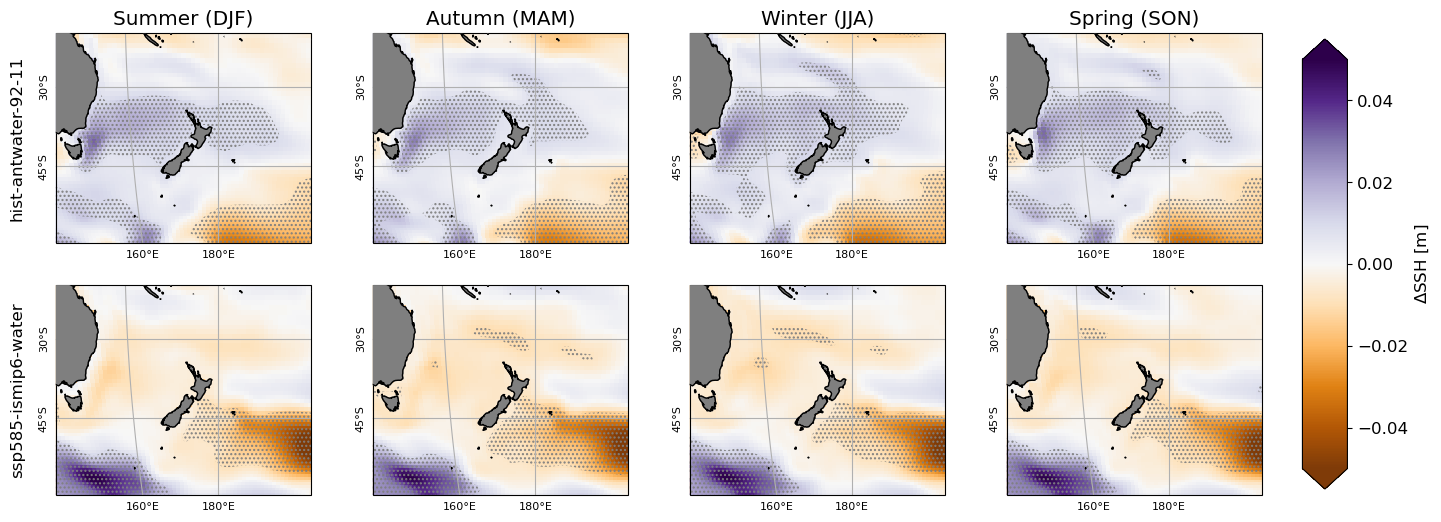

In [48]:
fig, axs = plt.subplots(
    2,
    4,
    figsize=(18, 6),
    subplot_kw={"projection": ccrs.Robinson(central_longitude=180)},
)
for n, exp in enumerate(expts):
    for s, seas in enumerate(tanom.season.data):
        dplt = anomdictseas[exp].sel(season=seas)
        pplt = pvaldictseas[exp].sel(season=seas)

        if n == 0:
            im = plotnz(axs[n, s], dplt, pplt, seasdict[seas])
        else:
            im = plotnz(axs[n, s], dplt, pplt, "")

axs[0, 0].annotate(
    "hist-antwater-92-11",
    xy=(-0.15, 0.5),
    xycoords="axes fraction",
    rotation=90,
    ha="center",
    va="center",
)

axs[1, 0].annotate(
    "ssp585-ismip6-water",
    xy=(-0.15, 0.5),
    xycoords="axes fraction",
    rotation=90,
    ha="center",
    va="center",
)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.025, 0.75])
cb = plt.colorbar(im, cax=cbar_ax, extend="both")
cb.set_label("$\Delta$SSH [m]")

fig.savefig(
    f"../figures/zos_seas_sofia_tier2_combined_nz.png",
    bbox_inches="tight",
    dpi=300,
)